In [22]:
import sqlite3
import pandas as pd
database = "../hosts_usage/db.sqlite3"
conn = sqlite3.connect(database)

df = pd.read_sql("select * from cpu_usage", con=conn, parse_dates=True, index_col='time')
conn.close()

df['cpu_usage'] = df.usage / df.total * 100
df.drop(['id', 'total', 'usage', 'hosts_id'], axis=1, inplace=True)

df.tail(30)

,cpu_usage
time,
2020-08-12 21:58:57.988719,10.051546
2020-08-12 22:00:00.209238,12.853470
2020-08-12 22:01:02.889449,37.922078
2020-08-12 22:02:05.141216,29.667519
2020-08-12 22:03:07.379556,14.179104
2020-08-12 22:04:09.597759,21.683673
2020-08-12 22:05:11.869572,30.077121
2020-08-12 22:06:14.060246,14.285714
2020-08-12 22:07:16.320843,13.853904


In [42]:
import sqlite3
import pandas as pd
database = "../hosts_usage/db.sqlite3"

datetime = '2020-08-12 20:00:00'

def cpu_usage():

    conn = sqlite3.connect(database)

    df = pd.read_sql("select * from cpu_usage", con=conn)
    conn.close()
    df['cpu_usage'] = df.usage / df.total * 100
    df.drop(columns=['id', 'total', 'usage', 'hosts_id'], inplace=True)
    df.time = pd.to_datetime(df.time).dt.floor('T')
    df.set_index('time', inplace=True)
    filtro = (df.index >= pd.Timestamp(datetime))
    df = df[filtro]
    df = df.resample('T').ffill()
    return df

def ram_usage():

    conn = sqlite3.connect(database)

    df = pd.read_sql("select * from ram_usage", con=conn)
    conn.close()
    df['ram_usage'] = df.usage / df.total * 100
    df.drop(columns=['id', 'total', 'usage', 'hosts_id'], inplace=True)
    df.time = pd.to_datetime(df.time).dt.floor('T')
    df.set_index('time', inplace=True)
    filtro = (df.index >= pd.Timestamp(datetime))
    df = df[filtro]
    df = df.resample('T').ffill()
    return df

,cpu_usage
time,
2020-08-12 20:00:00,13.486005
2020-08-12 20:01:00,10.379747
2020-08-12 20:02:00,13.881748
2020-08-12 20:03:00,26.075949
2020-08-12 20:04:00,24.804178


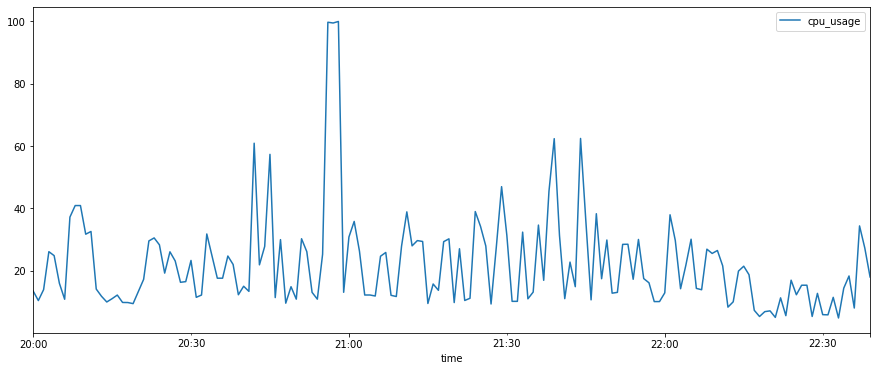

In [43]:
# CPU Usage
df = cpu_usage()
df.plot(figsize=(15,6))
df.head()

,ram_usage
time,
2020-08-12 20:00:00,30.020233
2020-08-12 20:01:00,30.500759
2020-08-12 20:02:00,30.589277
2020-08-12 20:03:00,30.665149
2020-08-12 20:04:00,30.728376


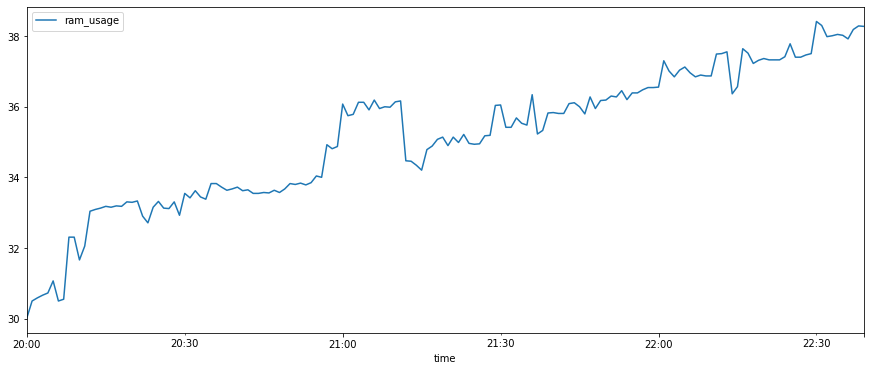

In [44]:
# Ram Usage
df = ram_usage()
df.plot(figsize=(15,6))
df.head()

In [53]:
df.head()

,ram_usage
time,
2020-08-10 22:25:00,29.312089
2020-08-10 22:26:00,29.122408
2020-08-10 22:27:00,28.768336
2020-08-10 22:28:00,28.844208
2020-08-10 22:29:00,28.920081


In [54]:
# Modelo Naive
df = ram_usage()
df['naive'] = df.ram_usage.shift(1)
df.head()

,ram_usage,naive
time,,
2020-08-10 22:25:00,29.312089,NaN
2020-08-10 22:26:00,29.122408,29.312089
2020-08-10 22:27:00,28.768336,29.122408
2020-08-10 22:28:00,28.844208,28.768336
2020-08-10 22:29:00,28.920081,28.844208


In [55]:
# Validação: Erro médio Quadrático
erro = (df.ram_usage - df.naive) ** 2
erro.mean()

0.10677559928960263

In [56]:
# Modelo AutoRegressivo
df = ram_usage()
df['x1'] = df.ram_usage.shift(1)
df.dropna(axis=0, inplace=True)
df.head()

,ram_usage,x1
time,,
2020-08-10 22:26:00,29.122408,29.312089
2020-08-10 22:27:00,28.768336,29.122408
2020-08-10 22:28:00,28.844208,28.768336
2020-08-10 22:29:00,28.920081,28.844208
2020-08-10 22:30:00,29.160344,28.920081


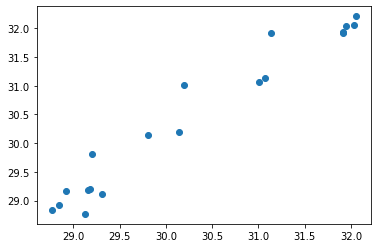

In [57]:
import matplotlib.pyplot as plt
plt.scatter(df.x1, df.ram_usage)

In [58]:
# 
from sklearn.linear_model import LinearRegression

X = df.x1.values # VALUES retorna um array
y = df.ram_usage.values
reg = LinearRegression().fit(X.reshape(-1, 1), y)
previsoes = reg.predict(X.reshape(-1, 1))

# Erro médio quadrático
((y - previsoes) ** 2).mean()

0.0833665385250431

Text(0, 0.5, 'ram_usage')

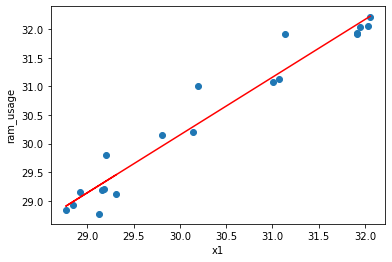

In [59]:
import matplotlib.pyplot as plt
plt.scatter(X, y)
plt.plot(X, reg.predict(X.reshape(-1, 1)), color='red')
plt.xlabel('x1')
plt.ylabel('ram_usage')

<AxesSubplot:xlabel='time'>

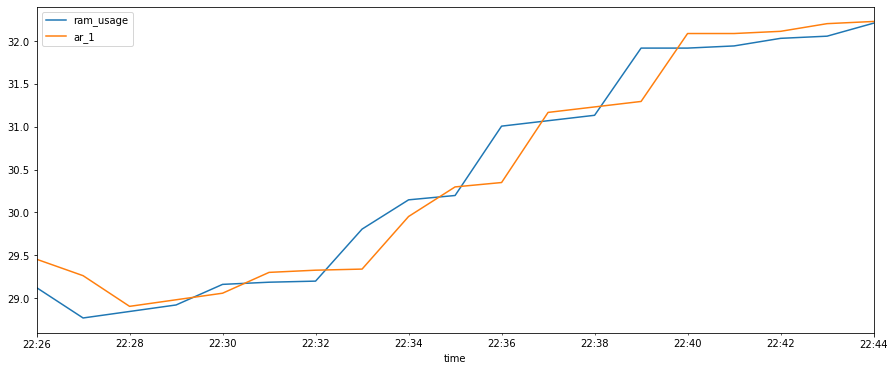

In [60]:
# Modelo AutoRegressivo de ordem 1
df['ar_1'] = previsoes
df[['ram_usage', 'ar_1']].plot(figsize=(15,6))

In [62]:
# Modelo AutoRegressivo de ordem 2
from statsmodels.tsa.ar_model import AR

df = ram_usage()
ar_2 = AR(df.ram_usage).fit(2)
# Erro médio quadrático
(ar_2.resid ** 2).mean()

0.07816058416562184

<AxesSubplot:xlabel='time'>

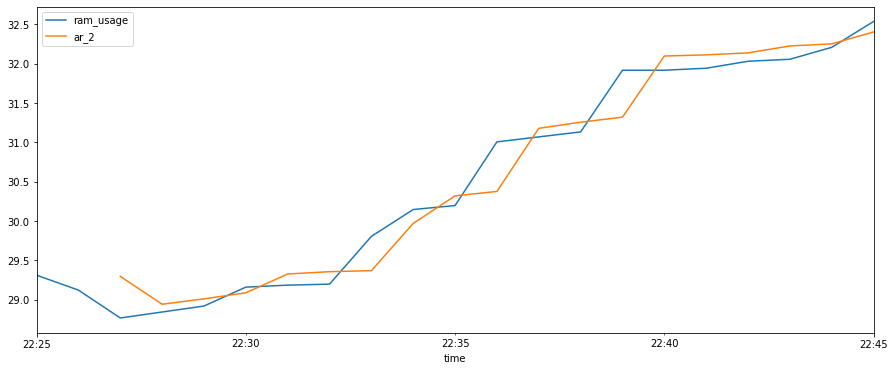

In [63]:
df['ar_2'] = ar_2.predict()
df.plot(figsize=(15,6))

In [88]:
# Modelo AutoRegressivo de ordem 3
df = ram_usage()
ar_3 = AR(df.ram_usage, freq='T').fit(3)
(ar_3.resid ** 2).mean()

0.06045753402666947

<AxesSubplot:xlabel='time'>

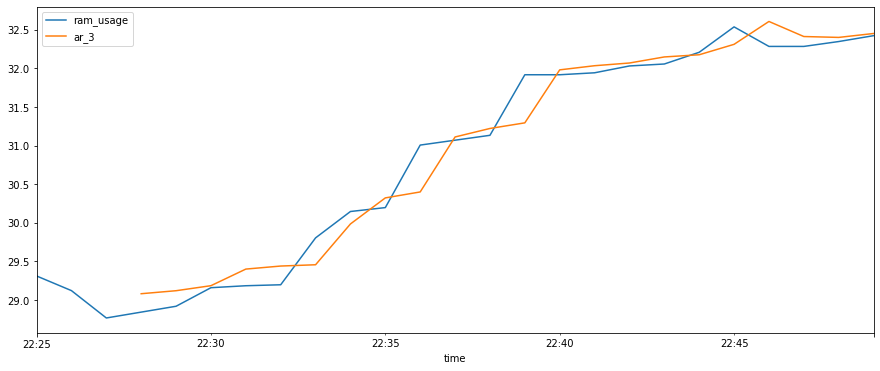

In [89]:
df['ar_3'] = ar_3.predict()
df.plot(figsize=(15,6))

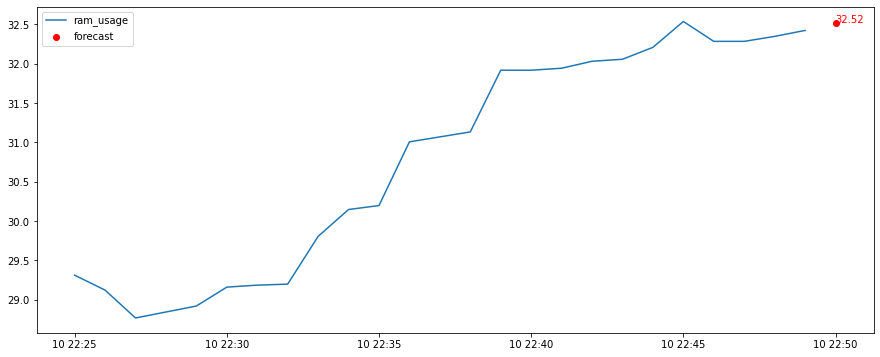

In [90]:
from datetime import datetime, timedelta

next_minute = str(df.index[-1] + timedelta(minutes=1))

plt.figure(figsize=(15, 6))
plt.plot(df.ram_usage)
forecast = ar_3.predict(start=next_minute, end=next_minute)
plt.scatter(forecast.index, forecast.values, color='red')
plt.text(forecast.index, forecast.values, "%.2f" % forecast[0], color='red')
plt.legend(['ram_usage', 'forecast'])

In [101]:
# Modelo AutoRegressivo de ordem 10
df = ram_usage()
ar_10 = AR(df.ram_usage, freq='T').fit(10)
(ar_10.resid ** 2).mean()

0.0748145272180842

<AxesSubplot:xlabel='time'>

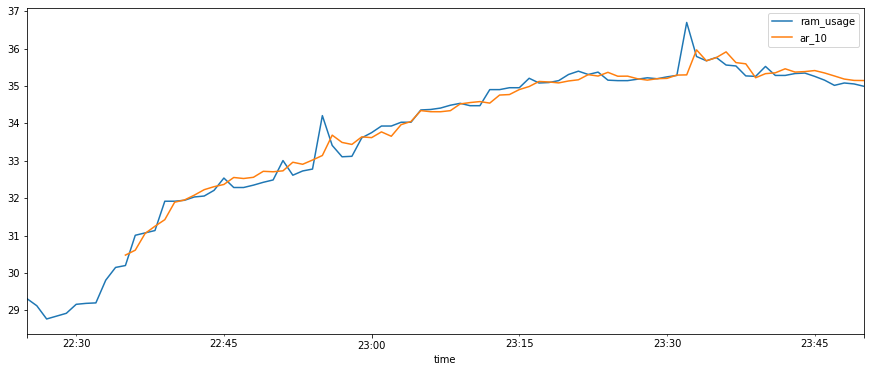

In [102]:
df['ar_10'] = ar_10.predict()
df.plot(figsize=(15,6))

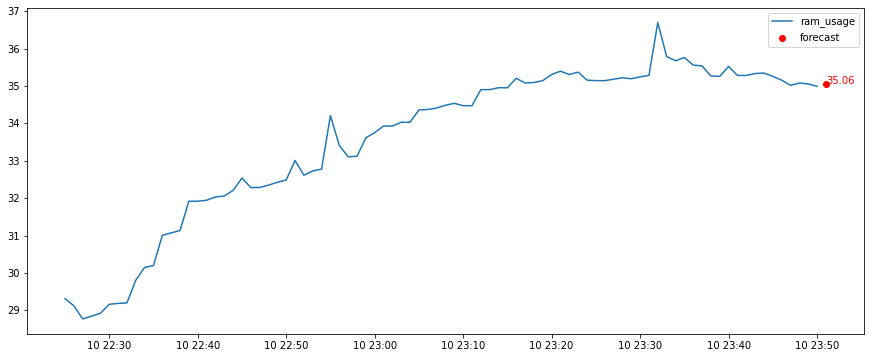

In [103]:

from datetime import datetime, timedelta

next_minute = str(df.index[-1] + timedelta(minutes=1))

plt.figure(figsize=(15, 6))
plt.plot(df.ram_usage)
forecast = ar_10.predict(start=next_minute, end=next_minute)
plt.scatter(forecast.index, forecast.values, color='red')
plt.text(forecast.index, forecast.values, "%.2f" % forecast[0], color='red')
plt.legend(['ram_usage', 'forecast'])

In [104]:
train_size = int(len(df.ram_usage) * 2/3)
train_size

57

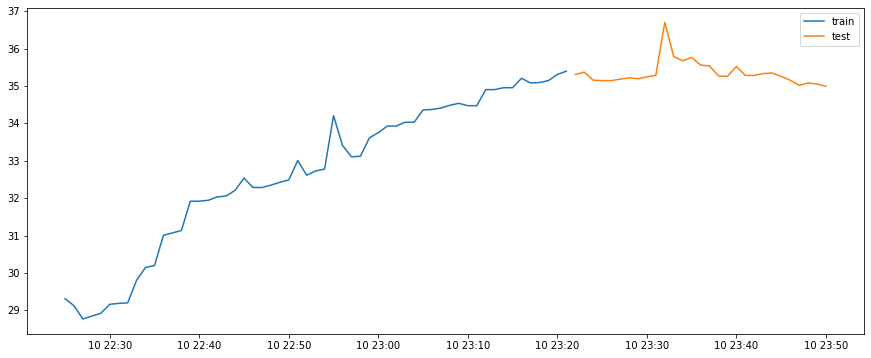

In [107]:
import matplotlib.pyplot as plt
train_set = df.ram_usage[:train_size]
test_set = df.ram_usage[train_size:]
plt.figure(figsize=(15, 6))
plt.plot(train_set)
plt.plot(test_set)
plt.legend(['train', 'test'])